# Does model misclassify specific disorder often as PD? Predicted probability for each disorder on test sets 

In [6]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation
from functools import reduce

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

In [7]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/analyses/acc_models/noOsteo'

In [8]:
dfs = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/merged_data/populationNoOsteoAllHC.csv',index_col=0)

(266, 181)
(8022, 181)
(24987, 181)
(24987, 181)
diagnosis             Status   
Healthy               Healthy      24987
AllCauseDementia      Prodromal       75
                      Diagnosed      390
AlzheimerDisease      Prodromal       65
                      Diagnosed       31
Dystonia              Diagnosed       18
Osteoarthritis        Prodromal      612
                      Diagnosed     6808
AllCauseParkinsonism  Prodromal        5
                      Diagnosed       18
ParkinsonDisease      Prodromal      113
                      Diagnosed      153
dtype: int64
(266, 181)
(8022, 181)
(24987, 181)
(24987, 181)
diagnosis             Status   
Healthy               Healthy      24987
AllCauseDementia      Prodromal       75
                      Diagnosed      390
AlzheimerDisease      Prodromal       65
                      Diagnosed       31
Dystonia              Diagnosed       18
Osteoarthritis        Prodromal      612
                      Diagnosed     6808
AllCa

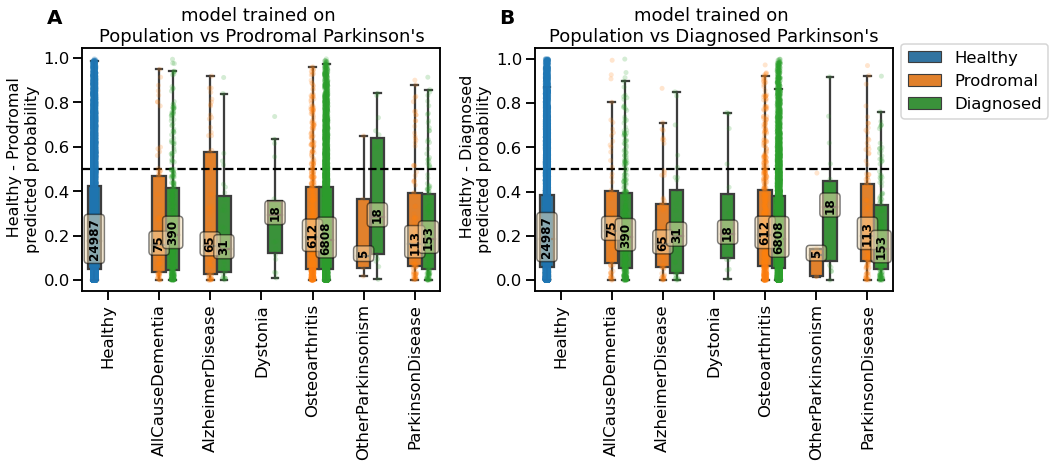

In [9]:
# load predictions
kind = ['all_acc_features']
diags = ['diag_ProdPopulationNoPD','diag_PDPopulationNoProd']
statuses = [["Prodromal"],['Diseased'],['Prodromal','Diseased']]
status_names = ['Prodromal','Diagnosed','Prodromal & Diagnosed']
hue_order=['Healthy','Prodromal','Diagnosed']
order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease']
remove = 20
subplotlabels = ['A','B','C']

fig,axes = plt.subplots(ncols=2,figsize=(15,7))
plots.plot_context()

for diag,status,status_name,ax,i in zip(diags,statuses,status_names,axes.flatten(),np.arange(len(diags))):
    for k in kind:
        pred = pd.read_csv(f'{data_path}/{k}/popmodelsNoPD_pred_stacked_allHC.csv',header=[0,1],index_col=[0,1])
        pred = pred.loc[:,(diag,'test')].to_frame().droplevel(level=0,axis=1)
        pred = pred[~pred['test'].isna()]
        #preddf = pd.merge(dfs,pred.loc[:,[(diag,'test')]],right_index=True,left_index=True,how='left')
        # remove PD patients from other diseases
        PDcases = dfs[np.logical_and(dfs['diagnosis']=='ParkinsonDisease',dfs['Status'].isin(statuses[-1]))]
        print(PDcases.shape)
        nonPD = dfs[np.logical_and(dfs['diagnosis']!='ParkinsonDisease',dfs['Status']!='Healthy')]
        nonPD = nonPD.drop(index=np.intersect1d(PDcases.index,nonPD.index))
        print(nonPD.shape)
        # merge HC in one group and drop duplicates
        hc = dfs[dfs['Status']=='Healthy']
        print(hc.shape)
        hc = hc[~hc.index.duplicated(keep='first')]
        print(hc.shape)
        preddf = pd.concat([PDcases,nonPD,hc])
        preddf['diagnosis'] = [row['diagnosis'] if row['Status']!='Healthy' else 'Healthy' for key,row in preddf.iterrows()]
        preddf = preddf[preddf['diagnosis'].isin(order)]
        preddf = preddf.reset_index().set_index(['eid','diagnosis'])
        merged = pd.merge(preddf,pred,right_index=True,left_index=True,how='right').reset_index().set_index('eid')
        merged['Status'] = merged['Status'].replace(['Diseased'],['Diagnosed'])
        
        merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status']).first()
        N_diagnosis_group = merged_cv.groupby(['diagnosis','Status']).size()
        N_diagnosis_group = N_diagnosis_group.loc[(order,hue_order)]

        merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status'])['test'].mean().reset_index()
        bp = sns.boxplot(y='test',x='diagnosis',hue='Status',data=merged_cv,showfliers=False,
                         hue_order=['Healthy','Prodromal','Diagnosed'],order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease'],ax=ax)
        sp = sns.stripplot(y='test',x='diagnosis',hue='Status',data=merged_cv,
                         hue_order=['Healthy','Prodromal','Diagnosed'],dodge=True,alpha=0.2,
                           order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease'],ax=ax)
        ax.axhline(0.5,0,1,ls='--',color='k')
        ax.set_ylabel(f'     Healthy - {status_name}\npredicted probability')
        #ax.text(-1.3,0.2,f'Healthy - {status_name}',rotation=90)
        ax.set_xticklabels(['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','OtherParkinsonism',
                                                                            'ParkinsonDisease'],rotation=90);
        print(N_diagnosis_group)
        plots.add_median_labels(ax,N_diagnosis_group,fmt="%d")
        ax.set_xlabel('')
        #ax.set_ylim(-0.05,1.05)
        ax.set_title(f"model trained on \nPopulation vs {status_name} Parkinson's")
        if i < len(diags):
            ax.legend([],[], frameon=False)
        ax.text(-0.1, 1.1, subplotlabels[i], transform=ax.transAxes, 
            size=20, weight='bold')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[:3],labels=labels[:3],bbox_to_anchor=(1, 1.05))
plt.tight_layout()
#plt.savefig(f'{image_path}/barplot_probacombined_populationmodel_{k}_stacked_cv_HCnoOsteo.pdf',dpi=300,bbox_inches='tight')
#plt.savefig(f'{image_path}/barplot_probacombined_populationmodel_{k}_stacked_cv_HCnoOsteo.png',dpi=300,bbox_inches='tight')
plt.show()

# Supplemental Figure

In [15]:
# check correlation of predictions
# load predictions
kind = ['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforePD','all_acc_features',
            'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
diags = ['diag_ProdPopulationNoPD','diag_PDPopulationNoProd']
statuses = [["Prodromal"],['Diseased'],['Prodromal','Diseased']]
status_names = ['Prodromal','Diagnosed','Prodromal & Diagnosed']
hue_order=['Healthy','Prodromal','Diagnosed']
order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease']

mergeds = []
for diag,status,status_name,i in zip([diags[0]],statuses,status_names,np.arange(len(diags))):
    merged_cvs = []
    for k in kind:
        pred = pd.read_csv(f'{data_path}/{k}/popmodelsNoPD_pred_stacked_allHC.csv',header=[0,1],index_col=[0,1])
        pred = pred.loc[:,(diag,'test')].to_frame().droplevel(level=0,axis=1)
        pred = pred[~pred['test'].isna()]
        #preddf = pd.merge(dfs,pred.loc[:,[(diag,'test')]],right_index=True,left_index=True,how='left')
        # remove PD patients from other diseases
        PDcases = dfs[np.logical_and(dfs['diagnosis']=='ParkinsonDisease',dfs['Status'].isin(statuses[-1]))]
        nonPD = dfs[np.logical_and(dfs['diagnosis']!='ParkinsonDisease',dfs['Status']!='Healthy')]
        nonPD = nonPD.drop(index=np.intersect1d(PDcases.index,nonPD.index))
        # merge HC in one group and drop duplicates
        hc = dfs[dfs['Status']=='Healthy']
        hc = hc[~hc.index.duplicated(keep='first')]
        preddf = pd.concat([PDcases,nonPD,hc])
        preddf['diagnosis'] = [row['diagnosis'] if row['Status']!='Healthy' else 'Healthy' for key,row in preddf.iterrows()]
        preddf = preddf[preddf['diagnosis'].isin(order)]
        preddf = preddf.reset_index().set_index(['eid','diagnosis'])
        merged = pd.merge(preddf,pred,right_index=True,left_index=True,how='right').reset_index().set_index('eid')
        merged['Status'] = merged['Status'].replace(['Diseased'],['Diagnosed'])
        
        merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status']).first()
        N_diagnosis_group = merged_cv.groupby(['diagnosis','Status']).size()
        N_diagnosis_group = N_diagnosis_group.loc[(order,hue_order)]

        merged_cv = merged.reset_index().groupby(['eid','diagnosis','Status'])['test'].mean().reset_index()
        merged_cv = merged_cv.rename(columns={'test':k})
        merged_cvs.append(merged_cv)
    merged = reduce(lambda  left,right: pd.merge(left,right,on=['eid','diagnosis','Status'],
                                            how='outer'), merged_cvs)
    mergeds.append(merged)

In [16]:
corr = pd.DataFrame(index = pd.MultiIndex.from_product([kind,kind],names=['modality 1','modality 2']),columns=['pearsonr','p-value'])
for i,k in enumerate(kind):
    for j,k2 in enumerate(kind):
        #if j>i:
            r,p = stats.pearsonr(mergeds[0][k],mergeds[0][k2])
            corr.loc[(k,k2),'pearsonr'] = r
            corr.loc[(k,k2),'p-value'] = p
#corr = corr.dropna(axis='rows',how='all')

In [20]:
corr['pearsonr'].unstack().astype(float).loc[kind,kind]

modality 2,intercept,genetics+family,lifestyle_nofam,blood,prodromalsigns_beforePD,all_acc_features,all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD
modality 1,,,,,,,
intercept,1.000000,0.005171,-0.006440,0.007814,0.009087,0.005468,0.006835
genetics+family,0.005171,1.000000,0.252974,0.386459,0.329500,0.304804,0.352154
lifestyle_nofam,-0.006440,0.252974,1.000000,0.402349,0.396964,0.356399,0.298180
blood,0.007814,0.386459,0.402349,1.000000,0.510010,0.528397,0.578478
prodromalsigns_beforePD,0.009087,0.329500,0.396964,0.510010,1.000000,0.398277,0.500197
all_acc_features,0.005468,0.304804,0.356399,0.528397,0.398277,1.000000,0.736511
all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD,0.006835,0.352154,0.298180,0.578478,0.500197,0.736511,1.000000


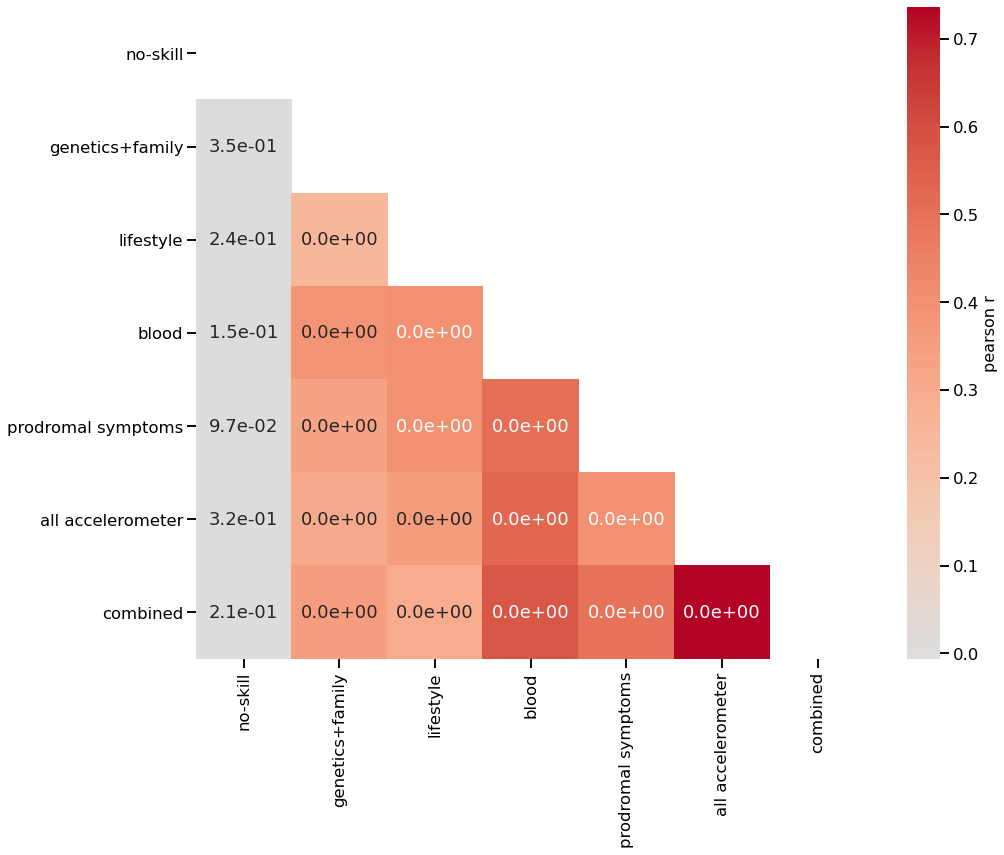

In [22]:
order=['Healthy','AllCauseDementia','AlzheimerDisease','Dystonia','Osteoarthritis','AllCauseParkinsonism',
                                                                            'ParkinsonDisease']
fig = plt.figure(figsize=(15,12))
plots.plot_context()
ax = sns.heatmap(corr['pearsonr'].unstack().astype(float).loc[kind,kind],cmap='coolwarm',center=0,
                 annot=corr['p-value'].unstack().astype(float).loc[kind,kind],fmt='.1e',xticklabels=['no-skill','genetics+family','lifestyle','blood','prodromal symptoms',
                                                'all accelerometer','combined'], yticklabels=['no-skill','genetics+family','lifestyle','blood','prodromal symptoms',
                                                'all accelerometer','combined'],cbar_kws={'label': 'pearson r'},mask=np.triu(corr['pearsonr'].unstack().astype(float)))
ax.set_xlabel('')
ax.set_ylabel('');
plt.savefig(f'{image_path}/testpredcorr.png',dpi=300,bbox_inches='tight')
plt.savefig(f'{image_path}/testpredcorr.pdf',dpi=300,bbox_inches='tight')

In [23]:
0.05/(len(kind))

0.0071428571428571435